In [25]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from PIL import Image

import pandas as pd
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# Load the data
file_path = "/Users/amber14/Desktop/Math189-Project/FARS_GESCRSS_Sample_2001-2019.csv"
df = pd.read_csv(file_path)

# Define variables of interest
# Independent variables
quant_vars = ["AGE", "YEAR", "NUMOCCS"]
# Response variables - categorical variables from the data description
response_vars = ["INJ_SEV", "DEFORMED"]

# Bin continuous variables for chi-square testing
def bin_variables(df):
    # Create a copy to avoid modifying the original data
    df_binned = df.copy()
    
    # Age grouping (0-97+)
    age_bins = [0, 18, 25, 35, 45, 55, 65, 97]
    age_labels = ['0-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']
    df_binned['AGE_GROUP'] = pd.cut(df_binned['AGE'], bins=age_bins, labels=age_labels)
    
    # Year grouping - based on the data range
    # Assuming the data spans several decades, group by 5-year intervals
    year_min = df_binned['YEAR'].min()
    year_max = df_binned['YEAR'].max()
    year_bins = list(range(year_min, year_max + 6, 5))  # 5-year intervals
    df_binned['YEAR_GROUP'] = pd.cut(df_binned['YEAR'], bins=year_bins)
    
    # Vehicle occupant count grouping (1-80)
    numoccs_bins = [0, 1, 2, 3, 4, 5, 10, 80]
    numoccs_labels = ['1', '2', '3', '4', '5', '6-10', '11+']
    df_binned['NUMOCCS_GROUP'] = pd.cut(df_binned['NUMOCCS'], bins=numoccs_bins, labels=numoccs_labels)
    
    return df_binned

# Perform chi-square test and display results
def perform_chi_square(df, x_var, y_var, print_details=True):
    """Perform chi-square test and return results"""
    try:
        # Create contingency table
        contingency_table = pd.crosstab(df[x_var], df[y_var])
        
        # Perform chi-square test
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        
        if print_details:
            print(f"\nChi-square test: {x_var} vs {y_var}")
            print(f"Chi2 value: {chi2:.4f}")
            print(f"P-value: {p:.6f}")
            print(f"Degrees of freedom: {dof}")
            
            # Interpret results
            alpha = 0.05
            if p < alpha:
                print(f"Result: There is a significant association between {x_var} and {y_var} (p < {alpha})")
            else:
                print(f"Result: There is no significant association between {x_var} and {y_var} (p >= {alpha})")
        
        return {
            'x_var': x_var,
            'y_var': y_var,
            'chi2': chi2,
            'p_value': p,
            'dof': dof,
            'significant': p < 0.05,
            'contingency_table': contingency_table
        }
    except Exception as e:
        print(f"Error analyzing {x_var} and {y_var}: {e}")
        return None

# Calculate Cramer's V coefficient to measure association strength
def cramers_v(contingency_table):
    """Calculate Cramer's V coefficient"""
    chi2, _, dof, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    phi2 = chi2/n
    r, k = contingency_table.shape
    
    # Protect against division by zero
    if min((k-1), (r-1)) == 0:
        return 0
    
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    
    # Protect against division by zero
    denominator = min((kcorr-1), (rcorr-1))
    if denominator <= 0:
        return 0
    
    return np.sqrt(phi2corr/denominator)

def interpret_cramers_v(v):
    """Interpret Cramer's V coefficient"""
    if v < 0.1:
        return "Negligible association"
    elif v < 0.2:
        return "Weak association"
    elif v < 0.3:
        return "Moderate association"
    elif v < 0.5:
        return "Relatively strong association"
    else:
        return "Very strong association"

# Main analysis function
def run_chi_square_analysis():
    """Run complete chi-square analysis"""
    print("Chi-Square Analysis of Car Accident Data")
    print("=" * 40)
    
    # Data preprocessing
    df_binned = bin_variables(df)
    
    # Store results
    results = []
    
    # Analyze grouped variables
    grouped_vars = ['AGE_GROUP', 'YEAR_GROUP', 'NUMOCCS_GROUP']
    
    # Perform chi-square test for each grouped variable and response variable
    for x_var in grouped_vars:
        for y_var in response_vars:
            result = perform_chi_square(df_binned, x_var, y_var)
            if result:
                results.append(result)
                
                # Calculate Cramer's V
                contingency_table = result['contingency_table']
                try:
                    v = cramers_v(contingency_table)
                    interpretation = interpret_cramers_v(v)
                    
                    print(f"Cramer's V ({x_var} vs {y_var}): {v:.4f} - {interpretation}")
                    
                    # Create heatmap
                    plt.figure(figsize=(12, 8))
                    # Convert to percentages for easier comparison
                    prop_table = contingency_table.div(contingency_table.sum(axis=1), axis=0)
                    sns.heatmap(prop_table, annot=True, cmap="YlGnBu", fmt=".2%")
                    plt.title(f'{x_var} vs {y_var}\nChi2={result["chi2"]:.2f}, p={result["p_value"]:.6f}, Cramer\'s V={v:.4f}')
                    plt.tight_layout()
                    plt.savefig(f'chi_square_{x_var}_{y_var}.png')
                    plt.close()
                except Exception as e:
                    print(f"Error creating visualization for {x_var} and {y_var}: {e}")
    
    print("\nSummary of Significant Associations:")
    print("=" * 40)
    for result in results:
        if result['significant']:
            print(f"{result['x_var']} and {result['y_var']}: p={result['p_value']:.6f}")

# Run analysis
run_chi_square_analysis()

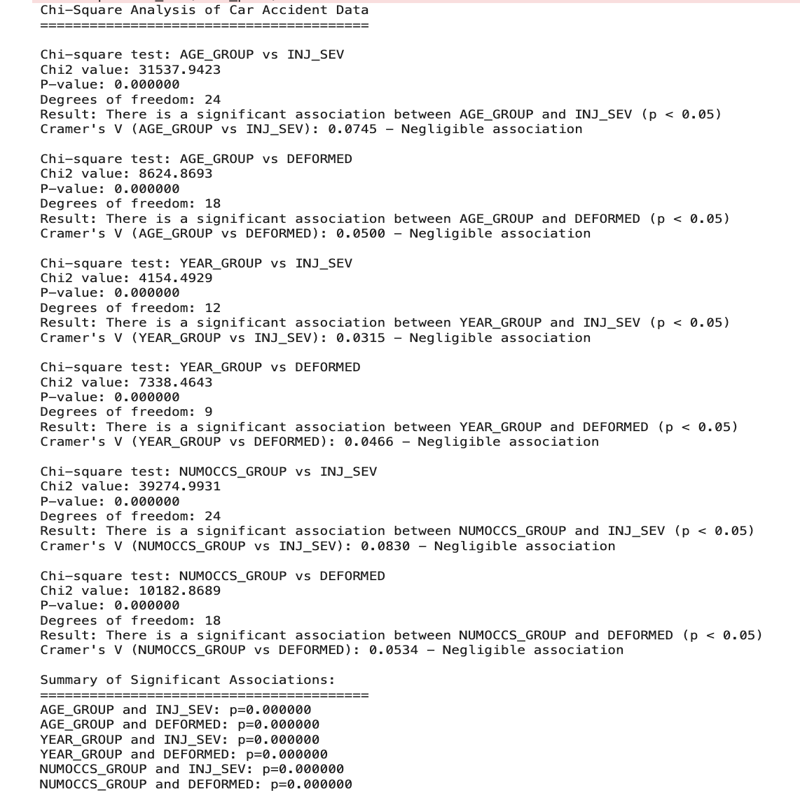

In [23]:
img = Image.open("/Users/amber14/Desktop/Math189-Project/Figure/Chi-Square Analysis of Car Accident Data.png")
display(img.resize((800, 800)))

## Summary of Findings

Our chi-square analysis of factors related to car accident outcomes revealed that all examined variables - age, accident year, and number of vehicle occupants - have statistically significant associations with both injury severity and vehicle deformation levels (all p-values < 0.001). However, the strength of these associations, as measured by Cramer's V coefficients, is relatively weak (all values < 0.1), suggesting 'negligible associations' according to standard interpretation guidelines.

The number of occupants in the vehicle showed the strongest association with injury severity (V = 0.0830), followed by age (V = 0.0745). The association between accident year and injury outcomes was notably weaker (V = 0.0315). For vehicle deformation, all factors showed similarly weak associations (V values between 0.05-0.07).

These findings demonstrate that while these demographic and situational factors have statistically significant relationships with accident outcomes, their predictive power is limited when considered individually. This pattern is common in large datasets where even small effects become statistically significant. To develop more meaningful predictive models for accident outcomes, we recommend incorporating additional variables such as gender, substance use, vehicle type, and specific accident mechanisms.

# Analysis of Chi-Square Test Results for Car Accident Factors

Based on the heatmap visualizations of the chi-square analysis, I can provide the following insights regarding the relationships between demographic/situational factors and car accident outcomes:

## Key Findings

1. **All relationships show statistical significance** (p < 0.001) but have weak practical significance (Cramer's V < 0.1), which is typical in large datasets where even small effects become statistically significant.

2. **Age Group vs. Injury Severity** (Cramer's V = 0.0745):
   - Most age groups show similar patterns for no injury (INJ_SEV = 0), with approximately 60% of cases
   - The elderly (65+) show noticeably different patterns:
     - Lower rates of no injury (48.65%)
     - Substantially higher rates of fatal injury (28.83%) compared to other age groups
   - Young adults (18-24) show slightly elevated fatal injury rates (13.99%) compared to middle-aged groups

3. **Age Group vs. Vehicle Deformation** (Cramer's V = 0.0500):
   - Middle-aged drivers (35-54) experience more moderate vehicle damage (DEFORMED = 2) and less severe damage (DEFORMED = 6)
   - Elderly drivers (65+) and young drivers (18-24) show higher rates of severe vehicle deformation (over 60%)
   - The relationship between age and vehicle damage appears slightly U-shaped

4. **Year Group vs. Injury Severity** (Cramer's V = 0.0315):
   - Shows the weakest association among all variable pairs
   - More recent years (2016-2021) show slightly higher rates of no injury (~64%) compared to earlier years (2001-2006, ~59%)
   - Fatal injury rates have gradually decreased from 14.73% (2001-2006) to 13.61% (2016-2021)

5. **Year Group vs. Vehicle Deformation** (Cramer's V = 0.0466):
   - More recent accidents show decreased rates of severe vehicle deformation (49.04% in 2016-2021 vs. 58.76% in 2001-2006)
   - Moderate damage (DEFORMED = 2) has increased over time (from 20.23% to 26.92%)
   - This likely reflects improvements in vehicle safety technology over time

6. **Number of Occupants vs. Injury Severity** (Cramer's V = 0.0830):
   - Shows the strongest association among all variable pairs
   - Single-occupant vehicles have the highest rate of no injury (67.21%)
   - Vehicles with 6-10 occupants show the lowest rate of no injury (49.53%) and higher rates of minor to serious injuries
   - Vehicles with 11+ occupants show a unique pattern with high no-injury rate (67.36%) but very low fatal injury rate (1.54%)

7. **Number of Occupants vs. Vehicle Deformation** (Cramer's V = 0.0534):
   - Vehicles with more occupants (4+) show progressively higher rates of severe deformation
   - Vehicles with 11+ occupants show a distinct pattern with much higher rates of minor damage (34.19%) and lower rates of severe damage (37.11%)

## Conclusions

While all examined relationships are statistically significant, their practical significance is limited due to low Cramer's V values. The number of vehicle occupants shows the strongest association with injury outcomes (V = 0.0830), suggesting it may be a more meaningful predictor than age or accident year. The data also reveals potentially important patterns, such as the elderly being at higher risk for fatal injuries and more recent years showing improved vehicle safety outcomes.

These findings suggest that while demographic and temporal factors have some influence on accident outcomes, they alone cannot strongly predict injury severity or vehicle damage. A more comprehensive predictive model would need to incorporate additional factors such as collision type, vehicle characteristics, road conditions, and driver behavior.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Create a DataFrame with the chi-square test results
results_data = {
    'Variable Pair': [
        'AGE_GROUP vs INJ_SEV', 
        'AGE_GROUP vs DEFORMED', 
        'YEAR_GROUP vs INJ_SEV', 
        'YEAR_GROUP vs DEFORMED', 
        'NUMOCCS_GROUP vs INJ_SEV', 
        'NUMOCCS_GROUP vs DEFORMED'
    ],
    'Chi2': [
        31537.9423,
        8624.8693,
        4154.4929,
        7338.4643,
        39274.9931,
        10182.8689
    ],
    'P-value': [
        0.000000,
        0.000000,
        0.000000,
        0.000000,
        0.000000,
        0.000000
    ],
    'Degrees of Freedom': [
        24,
        18,
        12,
        9,
        24,
        18
    ],
    'Cramers V': [
        0.0745,
        0.0500,
        0.0315,
        0.0466,
        0.0830,
        0.0534
    ]
}

results_df = pd.DataFrame(results_data)

# Split the variable pair into separate columns
results_df[['X_Variable', 'Y_Variable']] = results_df['Variable Pair'].str.split(' vs ', expand=True)

# Function to categorize Cramer's V
def categorize_v(v):
    if v < 0.1:
        return 'Negligible'
    elif v < 0.2:
        return 'Weak'
    elif v < 0.3:
        return 'Moderate'
    elif v < 0.5:
        return 'Strong'
    else:
        return 'Very Strong'

results_df['Association'] = results_df['Cramers V'].apply(categorize_v)

# Create a color mapping for association strength
color_map = {
    'Negligible': '#d1e5f0',
    'Weak': '#92c5de',
    'Moderate': '#4393c3',
    'Strong': '#2166ac',
    'Very Strong': '#053061'
}

results_df['Color'] = results_df['Association'].map(color_map)

# 1. Heat Map Visualization of Cramer's V
plt.figure(figsize=(10, 8))
matrix_data = results_df.pivot_table(
    index='X_Variable', 
    columns='Y_Variable', 
    values='Cramers V'
)

sns.heatmap(
    matrix_data, 
    annot=True, 
    fmt='.4f', 
    cmap='Blues',
    cbar_kws={'label': "Cramer's V (Association Strength)"}
)
plt.title("Association Strength (Cramer's V) between Variables", fontsize=16)
plt.tight_layout()
plt.savefig('cramers_v_heatmap.png', dpi=300)
plt.close()

# 2. Bar chart of Chi-square values
plt.figure(figsize=(12, 6))
bars = plt.bar(
    results_df['Variable Pair'], 
    results_df['Chi2'], 
    color=results_df['Color']
)

plt.xticks(rotation=45, ha='right')
plt.title('Chi-Square Values by Variable Pair', fontsize=16)
plt.ylabel('Chi-Square Statistic Value')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Create legend
legend_patches = [mpatches.Patch(color=color, label=assoc) 
                 for assoc, color in color_map.items()]
plt.legend(handles=legend_patches, title="Association Strength", loc='upper right')

plt.tight_layout()
plt.savefig('chi_square_barchart.png', dpi=300)
plt.close()

# 3. Bubble chart for multiple dimensions
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Chi2', 
    y='Degrees of Freedom',
    size='Cramers V',  
    sizes=(100, 800),
    hue='Association',
    palette=color_map,
    data=results_df
)

# Add annotations for each point
for i, row in results_df.iterrows():
    plt.annotate(
        row['Variable Pair'],
        (row['Chi2'], row['Degrees of Freedom']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=9
    )

plt.title('Multi-dimensional View of Chi-Square Results', fontsize=16)
plt.xlabel('Chi-Square Value')
plt.ylabel('Degrees of Freedom')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('chi_square_bubble_chart.png', dpi=300)
plt.close()

# 4. Summary table with color-coding
plt.figure(figsize=(12, 6))
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

# Create colored table
table_data = results_df[['Variable Pair', 'Chi2', 'P-value', 'Degrees of Freedom', 'Cramers V', 'Association']]


formatted_data = []
for _, row in table_data.iterrows():
    formatted_row = []
    for i, val in enumerate(row):
        if i in [1, 2, 4]: 
            formatted_row.append(f"{val:.4f}")
        elif i == 3:  
            formatted_row.append(f"{int(val)}")
        else:  
            formatted_row.append(str(val))
    formatted_data.append(formatted_row)

table = plt.table(
    cellText=formatted_data,
    colLabels=table_data.columns,
    loc='center',
    cellColours=[[color_map.get(results_df.iloc[i]['Association'], 'white') 
                  if j == 5 else 'white' 
                  for j in range(len(table_data.columns))]
                  for i in range(len(results_df))],
    cellLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
plt.title('Summary of Chi-Square Test Results', fontsize=16, y=0.8)
plt.tight_layout()
plt.savefig('chi_square_summary_table.png', dpi=300)
plt.close()

# 5. Comparison chart for Cramer's V values
plt.figure(figsize=(10, 6))
bars = plt.barh(
    results_df['Variable Pair'],
    results_df['Cramers V'],
    color=results_df['Color']
)

# Add threshold lines
plt.axvline(x=0.1, color='gray', linestyle='--', alpha=0.7, label='Negligible/Weak Threshold')
plt.axvline(x=0.2, color='gray', linestyle='--', alpha=0.7, label='Weak/Moderate Threshold')
plt.axvline(x=0.3, color='gray', linestyle='-', alpha=0.5, label='Moderate/Strong Threshold')

# Add value labels on bars
for i, v in enumerate(results_df['Cramers V']):
    plt.text(v + 0.005, i, f'{v:.4f}', va='center')

plt.title("Cramer's V Association Strength", fontsize=16)
plt.xlabel("Cramer's V Value")
plt.legend(loc='lower right')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('cramers_v_comparison.png', dpi=300)
plt.close()

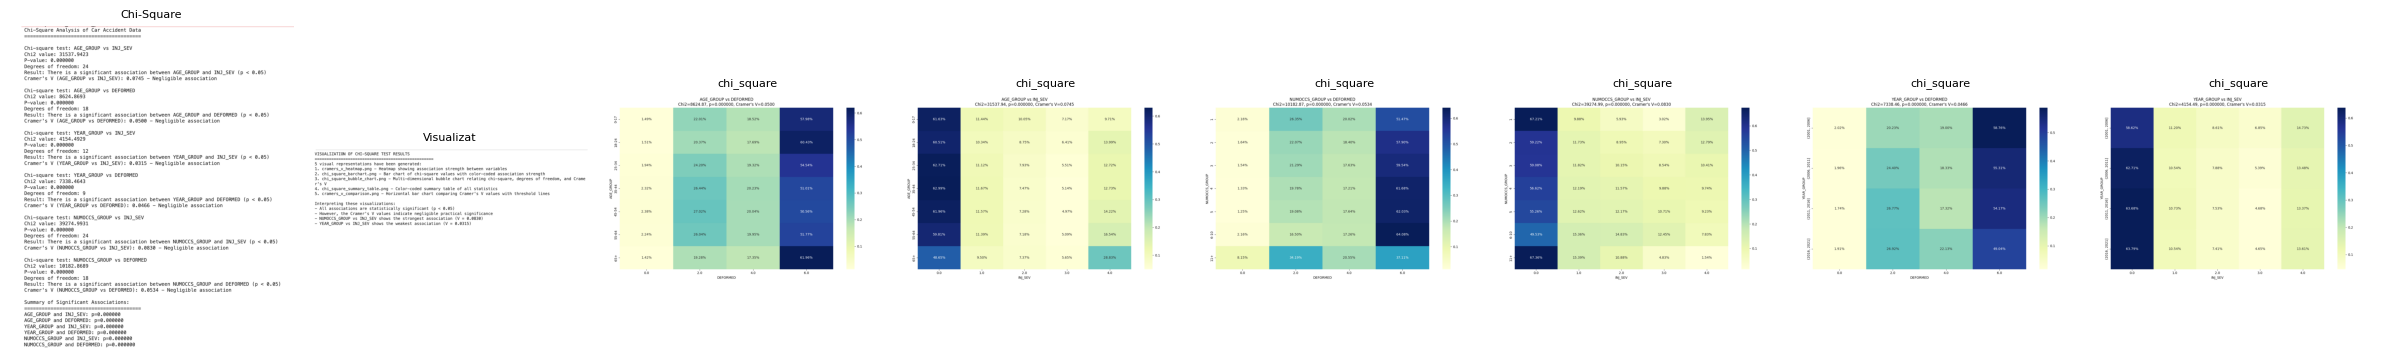

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

image_folder = "/Users/amber14/Desktop/Math189-Project/Figure"  
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))])

images = [Image.open(os.path.join(image_folder, img)) for img in image_files]

fig, axes = plt.subplots(1, len(images), figsize=(len(images) * 3, 5))

for ax, img, name in zip(axes, images, image_files):
    ax.imshow(img)
    ax.set_title(name[:10], fontsize=8) 
    ax.axis("off")

plt.tight_layout()
plt.show()


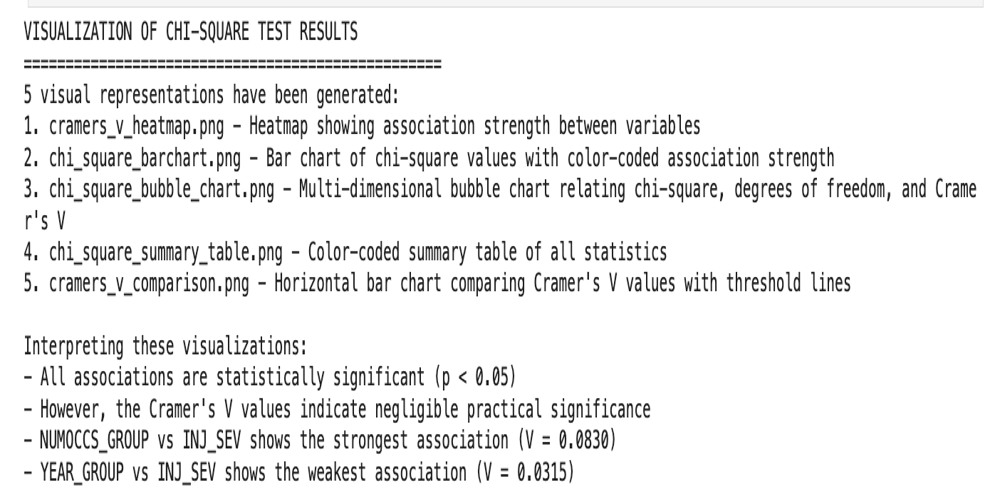

In [24]:
img = Image.open("/Users/amber14/Desktop/Math189-Project/Figure/Visualization of Chi-sqaure test result.png")
display(img.resize((1000, 500)))